# Credit Card Fraud Detection
### Models: Logistic Regression, Decision Tree, Random Forest, XGBoost
### Luke Schwenke
### May 4, 2023

## I. EDA & Feature Engineering

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
#from google.colab import drive 
#drive.mount('/content/gdrive')

In [47]:
train = pd.read_csv('/Users/lmschwenke/Downloads/fraudTrain.csv', index_col=0, parse_dates=['trans_date_trans_time', 'dob'])
test = pd.read_csv('/Users/lmschwenke/Downloads/fraudTest.csv', index_col=0, parse_dates=['trans_date_trans_time', 'dob'])
df = pd.concat([train, test])
df.shape

(1852394, 22)

In [48]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   merchant               object        
 3   category               object        
 4   amt                    float64       
 5   first                  object        
 6   last                   object        
 7   gender                 object        
 8   street                 object        
 9   city                   object        
 10  state                  object        
 11  zip                    int64         
 12  lat                    float64       
 13  long                   float64       
 14  city_pop               int64         
 15  job                    object        
 16  dob                    datetime64[ns]
 17  trans_num              object        
 18  unix_time              

### i. numeric variables

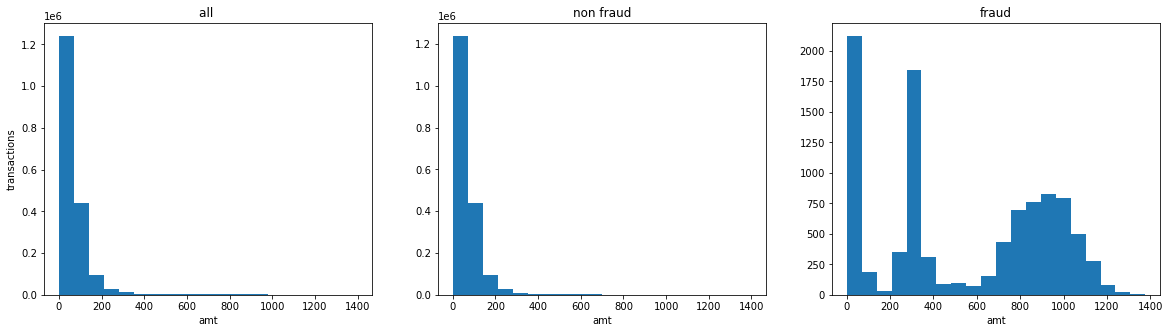

In [50]:
# amt
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_ylabel('transactions')

ax[0].set_xlabel('amt')
ax[1].set_xlabel('amt')
ax[2].set_xlabel('amt')

ax[0].set_title('all ')
ax[1].set_title('non fraud')
ax[2].set_title('fraud')

ax[0].hist(df.loc[df['amt']<=1400, 'amt'], bins=20)
ax[1].hist(df.loc[(df['amt']<=1400) & (df['is_fraud']==0), 'amt'], bins=20)
ax[2].hist(df.loc[(df['amt']<=1400) & (df['is_fraud']==1), 'amt'], bins=20);

### ii. datetime variables

In [51]:
# trans_date_trans_time
df['trans_date'] = df['trans_date_trans_time'].dt.date
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_ym'] = df['trans_date_trans_time'].dt.to_period('M')

In [52]:
df['agg'] = 1
df['index'] = df['trans_date_trans_time']
df = df.set_index('index').sort_index()

# rolling: 60 day transaction amount average by card number
df_amt_60d = df.groupby('cc_num')['amt'].rolling('60D').mean().shift().reset_index().fillna(0)
df_amt_60d.columns = ['cc_num','trans_date','avg_amt_60d']
df_amt_60d['trans_date'] = df_amt_60d['trans_date'].dt.date
df_amt_60d = df_amt_60d.groupby(['cc_num','trans_date'])['avg_amt_60d'].min().reset_index()

# rolling: 60 day transactions by card number
df_60d = df.groupby('cc_num')['agg'].rolling('60D').count().shift().reset_index().fillna(0)
df_60d.columns = ['cc_num','trans_date','60d']
df_60d['trans_date'] = df_60d['trans_date'].dt.date
df_60d = df_60d.groupby(['cc_num','trans_date'])['60d'].min().reset_index()

# merge by cc_num, trans_date
df = df.merge(df_amt_60d, left_on = ['cc_num','trans_date'], right_on = ['cc_num','trans_date'], how = 'left')\
    .merge(df_60d, left_on = ['cc_num','trans_date'], right_on = ['cc_num','trans_date'], how = 'left')
df[['avg_amt_60d','60d']]= df[['avg_amt_60d','60d']].fillna(0)

In [53]:
# age = trans_date_trans_time - dob
df['age'] = np.round((df['trans_date_trans_time'] - df['dob'])/np.timedelta64(1,'Y'))

### iii. categorical variables

In [54]:
# gender
(pd.crosstab(df['gender'], df['is_fraud'])/len(df)).sort_values(by=1)

is_fraud,0,1
gender,,
M,0.449631,0.002565
F,0.545159,0.002645


In [55]:
# category
(pd.crosstab(df['category'], df['is_fraud'])/len(df)).sort_values(by=1)

is_fraud,0,1
category,,
travel,0.031203,0.000084
grocery_net,0.034929,0.000094
health_fitness,0.066059,0.000100
food_dining,0.070462,0.000111
home,0.094578,0.000143
personal_care,0.070069,0.000157
entertainment,0.072245,0.000158
kids_pets,0.087143,0.000164
misc_pos,0.061492,0.000174


In [56]:
# one hot encoding
df = pd.concat([df, pd.get_dummies(df[['gender', 'category']], drop_first=True)], axis=1)

### iv. interactive visualizations

In [57]:
# amt by city, age, gender
from ipywidgets import interact
import plotly.graph_objects as go

fig = go.FigureWidget()
scatt = fig.add_histogram()

@interact(state=df['state'].unique(), gender=df['gender'].unique(), age=(14,100,5), is_fraud=[0,1])

def update(state='NC',gender='M', age=14, is_fraud=1):
    with fig.batch_update():
        scatt=df[(df['state'] == state) & (df['gender'] == gender) & (df['age'] >= age) & (df['is_fraud'] == is_fraud)]['amt']
        fig.data[0].x=scatt

fig.update_layout(xaxis_title="Transactions", yaxis_title="Transaction Amount")
fig.show()

interactive(children=(Dropdown(description='state', options=('NC', 'WA', 'ID', 'MT', 'VA', 'PA', 'KS', 'TN', '…

In [58]:
fig = go.Figure()
fig.add_trace(go.Scattergeo(
        locationmode='USA-states',
        lon=df[df['is_fraud'] == 1]['long'],
        lat=df[df['is_fraud'] == 1]['lat'],
        marker=dict(color=df[df['is_fraud'] == 1]['is_fraud'], line_color='rgb(40,40,40)', line_width=0.5, sizemode='area'),
        name='test'))
fig.update_layout(geo=dict(landcolor='rgb(217,217,217)',), mapbox_style="open-street-map")

In [59]:
import plotly.express as px 
fig = px.scatter_mapbox(df[df['is_fraud'] == 1], lat="lat", lon="long", hover_name="city",
                        zoom=3, height=500, color="is_fraud",  color_discrete_sequence=px.colors.cyclical.IceFire)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## II. Modeling

### i. correlation

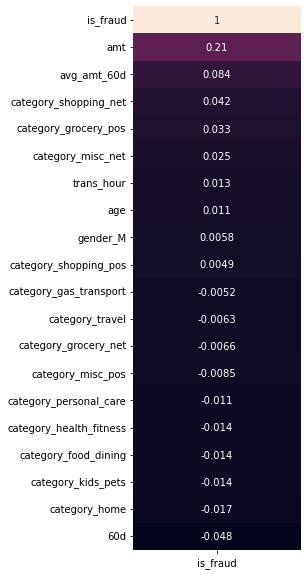

In [60]:
cols = ['amt', 'trans_hour', 'avg_amt_60d', '60d', 'age', 'gender_M', 
        'category_food_dining', 'category_gas_transport', 'category_grocery_net', 'category_grocery_pos', 
        'category_health_fitness', 'category_home', 'category_kids_pets', 'category_misc_net', 'category_misc_pos', 
        'category_personal_care', 'category_shopping_net', 'category_shopping_pos', 'category_travel']
import seaborn as sn
plt.figure(figsize=(3,10))
sn.heatmap(df[cols+['is_fraud']].corr()[['is_fraud']].sort_values(by='is_fraud', ascending=False), annot=True, cbar=False);

### ii. oversampling

In [61]:
df['is_fraud'].value_counts(normalize=True)

0    0.99479
1    0.00521
Name: is_fraud, dtype: float64

In [62]:
fraud_oversample = df[df['is_fraud'] == 1].sample(df[df['is_fraud'] == 0]['amt'].count(), replace=True)
df_oversampled = pd.concat([df[df['is_fraud'] == 0], fraud_oversample], axis=0)

In [63]:
df_oversampled['is_fraud'].value_counts()

0    1842743
1    1842743
Name: is_fraud, dtype: int64

###  iii. train test split

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_oversampled[cols], df_oversampled['is_fraud'], train_size=2/3)

In [65]:
X_train.shape

(2456990, 19)

In [89]:
y_train.value_counts()

0    1229286
1    1227704
Name: is_fraud, dtype: int64

In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

def model_results(model):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    print('train:')
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))
    print('test:')
    print(confusion_matrix(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))
    print("ROC AUC score:", roc_auc)
    return model

### iv. logistic regression

In [67]:
from sklearn.linear_model import LogisticRegression
model_results(LogisticRegression())

train:
[[1097533  131753]
 [ 258087  969617]]
              precision    recall  f1-score   support

           0       0.81      0.89      0.85   1229286
           1       0.88      0.79      0.83   1227704

    accuracy                           0.84   2456990
   macro avg       0.84      0.84      0.84   2456990
weighted avg       0.84      0.84      0.84   2456990

test:
[[548279  65178]
 [129239 485800]]
              precision    recall  f1-score   support

           0       0.81      0.89      0.85    613457
           1       0.88      0.79      0.83    615039

    accuracy                           0.84   1228496
   macro avg       0.85      0.84      0.84   1228496
weighted avg       0.85      0.84      0.84   1228496

ROC AUC score: 0.8418107771686087


LogisticRegression()

### v. decision tree

In [68]:
from sklearn.tree import DecisionTreeClassifier
dt = model_results(DecisionTreeClassifier(max_depth=3))

train:
[[1145560   83726]
 [ 201329 1026375]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89   1229286
           1       0.92      0.84      0.88   1227704

    accuracy                           0.88   2456990
   macro avg       0.89      0.88      0.88   2456990
weighted avg       0.89      0.88      0.88   2456990

test:
[[571498  41959]
 [100931 514108]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89    613457
           1       0.92      0.84      0.88    615039

    accuracy                           0.88   1228496
   macro avg       0.89      0.88      0.88   1228496
weighted avg       0.89      0.88      0.88   1228496

ROC AUC score: 0.8837486687527085


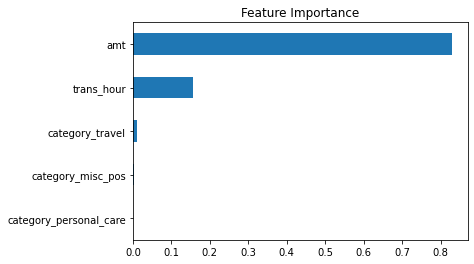

In [69]:
pd.Series(dt.feature_importances_, index=X_train.columns).sort_values().tail().plot(kind='barh', title='Feature Importance');

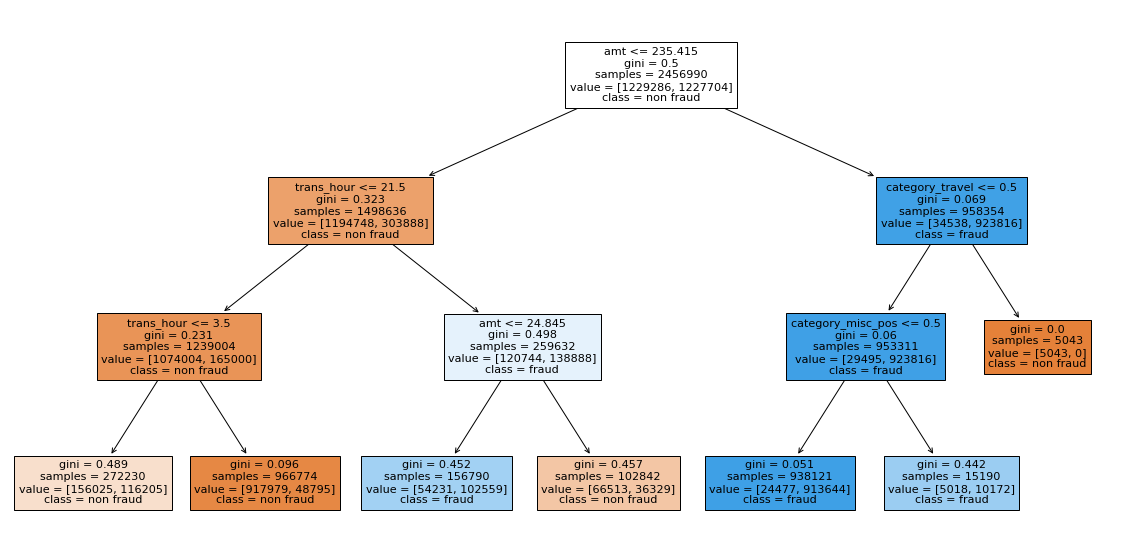

In [70]:
plt.figure(figsize=(20, 10))
from sklearn import tree
tree.plot_tree(dt, max_depth=3, feature_names=cols, class_names=['non fraud', 'fraud'], filled=True);

### vi. random forest

In [71]:
from sklearn.ensemble import RandomForestClassifier
model_results(RandomForestClassifier(n_estimators=10, max_depth=3))

train:
[[1159835   69451]
 [ 195041 1032663]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90   1229286
           1       0.94      0.84      0.89   1227704

    accuracy                           0.89   2456990
   macro avg       0.90      0.89      0.89   2456990
weighted avg       0.90      0.89      0.89   2456990

test:
[[578349  35108]
 [ 97617 517422]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90    613457
           1       0.94      0.84      0.89    615039

    accuracy                           0.89   1228496
   macro avg       0.90      0.89      0.89   1228496
weighted avg       0.90      0.89      0.89   1228496

ROC AUC score: 0.8920267353059195


RandomForestClassifier(max_depth=3, n_estimators=10)

### vii. xgboost

In [72]:
from xgboost import XGBClassifier
model_results(XGBClassifier(n_estimators=10, max_depth=3))

train:
[[1177620   51666]
 [  83454 1144250]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95   1229286
           1       0.96      0.93      0.94   1227704

    accuracy                           0.95   2456990
   macro avg       0.95      0.94      0.94   2456990
weighted avg       0.95      0.95      0.94   2456990

test:
[[587375  26082]
 [ 41738 573301]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95    613457
           1       0.96      0.93      0.94    615039

    accuracy                           0.94   1228496
   macro avg       0.95      0.94      0.94   1228496
weighted avg       0.95      0.94      0.94   1228496

ROC AUC score: 0.9448106047030045


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [78]:
xgb=XGBClassifier(n_estimators=10, max_depth=3).fit(X_train, y_train)

In [82]:
importances = xgb.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Print the top 5 features
print("Top 5 Features:")
for i in range(5):
    print(f"{i+1}. {names[i]} ({importances[indices[i]]:.4f})")

Top 5 Features:
1. amt (0.3360)
2. category_gas_transport (0.2358)
3. trans_hour (0.0975)
4. category_shopping_pos (0.0663)
5. category_shopping_net (0.0562)


In [87]:
df_oversampled.shape[0] - df.shape[0]

1833092

## Summary

The purpose of this modeling exercise is to use a credit card dataset to predict fraud. The dataset contains typical parameters related to a banking customer such as address, data of birth, credit card number, transaction amount, merchant, and more. 

The first point from the exploratory data analysis (EDA) that stood out is related to the amount variable. Not only is this variable the most significant in terms of correlation with predicting the fraud term (21%), but the distribution indicates that a lot of fraud occurs between the $600 and $1,200 range. This is interesting because non-fraudulent transactions are mainly below $400 meaning the higher the purchase generally the higher the chance of fraud. Other variables such as gender and physical location do not show as clear of indication of predicting fraud. Fraudulent transactions are committed by both genders equally at 0.25% and the location does not have particular patterns or clusters. Taking a look at the transaction category, some categories such as groceries and shopping indicate higher chances of fraud compared to types like travel. Intuitively these results make sense: people committing credit card fraud are less likely to charge something travel related that will not be used for months unlike food/groceries or general shopping. Additionally, people committing fraud may find it more worthwhile and likely to commit the crime if they are getting higher-value items.

To account for the extreme class imbalance, oversampling was done to make the count of fraud transactions more equal to non-fraud. The Test accuracy for the models were as follows: Logistic (84%), Decision Tree (88%), and Random Forest (87%), XGBoost (95%). All 4 models were stable between Train and Test indicating that they were not overfit to the training set. Examining the best performing XGBoost more closely, the accuracy indicates 95% of the total cases were classified correctly. The top 3 most important features for XGBoost according to their coefficient values were amount, category_gas_transport, and trans_hour meaning the gas transactions, higher value transactions, and the hour the transaction took place are all significant to predicting fraud.. The category_gas_transport was more of a surprise because it did not show as correlated with fraud in the EDA stage like the groceries and shopping categories. 

Overall, these models performed well in predicting fraud but the XGBoost performed best in part because it handles larger and complex datasets well. Our dataset was augmented by 1.8 million rows to account for class imbalance – this oversampling and model choice helped increase the prediction accuracy more than a simpler model that did not correct for imbalance would.
